In [1]:
import pandas as pd
import numpy as np
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import category_encoders as ce

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn.model_selection import train_test_split  # специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


In [5]:
hotels_train = pd.read_csv('data/hotels_train.csv') 
hotels_test = pd.read_csv('data/hotels_test.csv') 
submission = pd.read_csv('data/submission.csv') 

In [9]:
display(hotels_train.head())
display(hotels_test.head())
display(submission.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [10]:
# поиск и удаление дублей
mask = hotels_train.duplicated(subset=hotels_train.columns) # маска для фильтрации
data_duplicates = hotels_train[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [11]:
hotels_train.drop_duplicates(inplace=True)

In [12]:
# объединим данные

hotels_train['sample'] = 1 # данные для обучения
hotels_train['id'] = hotels_train.index
hotels_test['sample'] = 0 # данные для теста
hotels_test['reviewer_score'] = 0 # заполняем нулями тестовые данные для предсказания
hotels_test['id'] = hotels_test.index # задаем id в тестовых данных
data = hotels_train.copy()
data = pd.concat([hotels_train,hotels_test],axis=0,ignore_index=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [13]:
# находим и удаляем пропуски
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.634032
lng    0.634032
dtype: float64

In [14]:
data.drop(['lat', 'lng'], axis=1, inplace=True)

In [15]:
# извлечем количество дней между датой проверки и датой очистки в целочисленном формате и удалим старый признак.

regex = '\d+'
data['days_since_review_int'] = data['days_since_review'].str.findall(regex).str.get(0).astype('int')
data.drop(['days_since_review'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [17]:
# извлечем из адреса страну и город отеля и запишем в новый признак. 
# Добавим данные о количестве населения и площади города в отдельные признаки. Удалим исходный признак.

data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])

сity_population = {
    'Paris':  2148327, 'London': 8908081, 'Milan': 1366180, 
    'Vienna': 1911191, 'Barcelona': 1636732, 'Amsterdam': 860124
}
сity_area = {
    'Paris': 105, 'London': 1706, 'Milan': 181, 
    'Vienna': 414, 'Barcelona': 101, 'Amsterdam': 219
}

data['сity_population'] = data['hotel_city'].map(сity_population)
data['сity_area'] = data['hotel_city'].map(сity_area)

data.drop(['hotel_address'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

In [19]:
# выделим признаки месяца и года из даты отзыва, предварительно приведя признак к формату datetime. 
# Удалим первоначальный признак даты.

data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')
data['review_day'] = data['review_date'].dt.day.astype(int)
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_year'] = data['review_date'].dt.year.astype(int)
data['review_weekday'] = data['review_date'].dt.dayofweek.astype(int)
data.drop(['review_date'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

In [20]:
# преобразуем колонку 'tags' таким образом, чтобы остались только 10 наиболее популярных тэгов в значениях.

data['tags'] = data['tags'].apply(lambda x: x.lower())
data['tags_list'] = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))

# Получаем топ-10 тегов
top_tags = list(data['tags'].explode().value_counts().index)[:10]

# Реализуем вариант OneHotEncoder для топ-10 тегов
for t in top_tags:
    data[t] = data['tags'].apply(lambda x: 1 if t in x else 0)

data = data.drop(['tags'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 32 columns):
 #   Column                                                                                                             Non-Null Count   Dtype  
---  ------                                                                                                             --------------   -----  
 0   additional_number_of_scoring                                                                                       515431 non-null  int64  
 1   average_score                                                                                                      515431 non-null  float64
 2   hotel_name                                                                                                         515431 non-null  object 
 3   reviewer_nationality                                                                                               515431 non-null  object 
 4   negative_revie

In [21]:
# произведем кодировку признака hotel_city методом однократного кодирования (так как количество значений менее 10). 
# Удалим исходный признак.

encoder = ce.OneHotEncoder(cols=['hotel_city'])
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['hotel_city'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 37 columns):
 #   Column                                                                                                             Non-Null Count   Dtype  
---  ------                                                                                                             --------------   -----  
 0   additional_number_of_scoring                                                                                       515431 non-null  int64  
 1   average_score                                                                                                      515431 non-null  float64
 2   hotel_name                                                                                                         515431 non-null  object 
 3   reviewer_nationality                                                                                               515431 non-null  object 
 4   negative_revie

In [22]:
# произведем кодировку признака 'reviewer_nationality' методом двоичного кодирования 
# (так как количество значений более 200). Удалим исходный признак.

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['reviewer_nationality'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 44 columns):
 #   Column                                                                                                             Non-Null Count   Dtype  
---  ------                                                                                                             --------------   -----  
 0   additional_number_of_scoring                                                                                       515431 non-null  int64  
 1   average_score                                                                                                      515431 non-null  float64
 2   hotel_name                                                                                                         515431 non-null  object 
 3   negative_review                                                                                                    515431 non-null  object 
 4   review_total_n

In [23]:
# произведем кодировку признака hotel_name методом двоичного кодирования 
# (так как количество значений более 1400). Удалим исходный признак.

bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['hotel_name'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 54 columns):
 #   Column                                                                                                             Non-Null Count   Dtype  
---  ------                                                                                                             --------------   -----  
 0   additional_number_of_scoring                                                                                       515431 non-null  int64  
 1   average_score                                                                                                      515431 non-null  float64
 2   negative_review                                                                                                    515431 non-null  object 
 3   review_total_negative_word_counts                                                                                  515431 non-null  int64  
 4   total_number_o

In [24]:
# удалим оставшиеся текстовые признаки

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 51 columns):
 #   Column                                                                                                             Non-Null Count   Dtype  
---  ------                                                                                                             --------------   -----  
 0   additional_number_of_scoring                                                                                       515431 non-null  int64  
 1   average_score                                                                                                      515431 non-null  float64
 2   review_total_negative_word_counts                                                                                  515431 non-null  int64  
 3   total_number_of_reviews                                                                                            515431 non-null  int64  
 4   review_total_p

In [25]:
# удалим оставшиеся текстовые признаки

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 51 columns):
 #   Column                                                                                                             Non-Null Count   Dtype  
---  ------                                                                                                             --------------   -----  
 0   additional_number_of_scoring                                                                                       515431 non-null  int64  
 1   average_score                                                                                                      515431 non-null  float64
 2   review_total_negative_word_counts                                                                                  515431 non-null  int64  
 3   total_number_of_reviews                                                                                            515431 non-null  int64  
 4   review_total_p

In [26]:
train_data = data[data['sample'] == 1]
test_data = data[data['sample'] == 0]
train_data.index = train_data['id']
test_data.index = test_data['id']

train_data.drop(['sample','id'],axis=1,inplace=True)
test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 49 columns):
 #   Column                                                                                                             Non-Null Count   Dtype  
---  ------                                                                                                             --------------   -----  
 0   additional_number_of_scoring                                                                                       386496 non-null  int64  
 1   average_score                                                                                                      386496 non-null  float64
 2   review_total_negative_word_counts                                                                                  386496 non-null  int64  
 3   total_number_of_reviews                                                                                            386496 non-null  int64  
 4   review_total_p

/var/folders/g3/228f25rs4kbdn0x8dsvk8sv40000gn/T/ipykernel_3093/2911538065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['sample','id'],axis=1,inplace=True)
/var/folders/g3/228f25rs4kbdn0x8dsvk8sv40000gn/T/ipykernel_3093/2911538065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)


In [27]:
# непрерывные признаки

num_cols = ['average_score', 'sentiment_score', 'polarity_pos', 'polarity_neg', 
            'total_number_of_reviews', 'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'additional_number_of_scoring', 'days_since_review_int', 
            'сity_population', 'сity_area']

# категориальные признаки
cat_cols = ['review_day', 'review_month', 'review_year', 'review_weekday']   #'tags'

<AxesSubplot: >

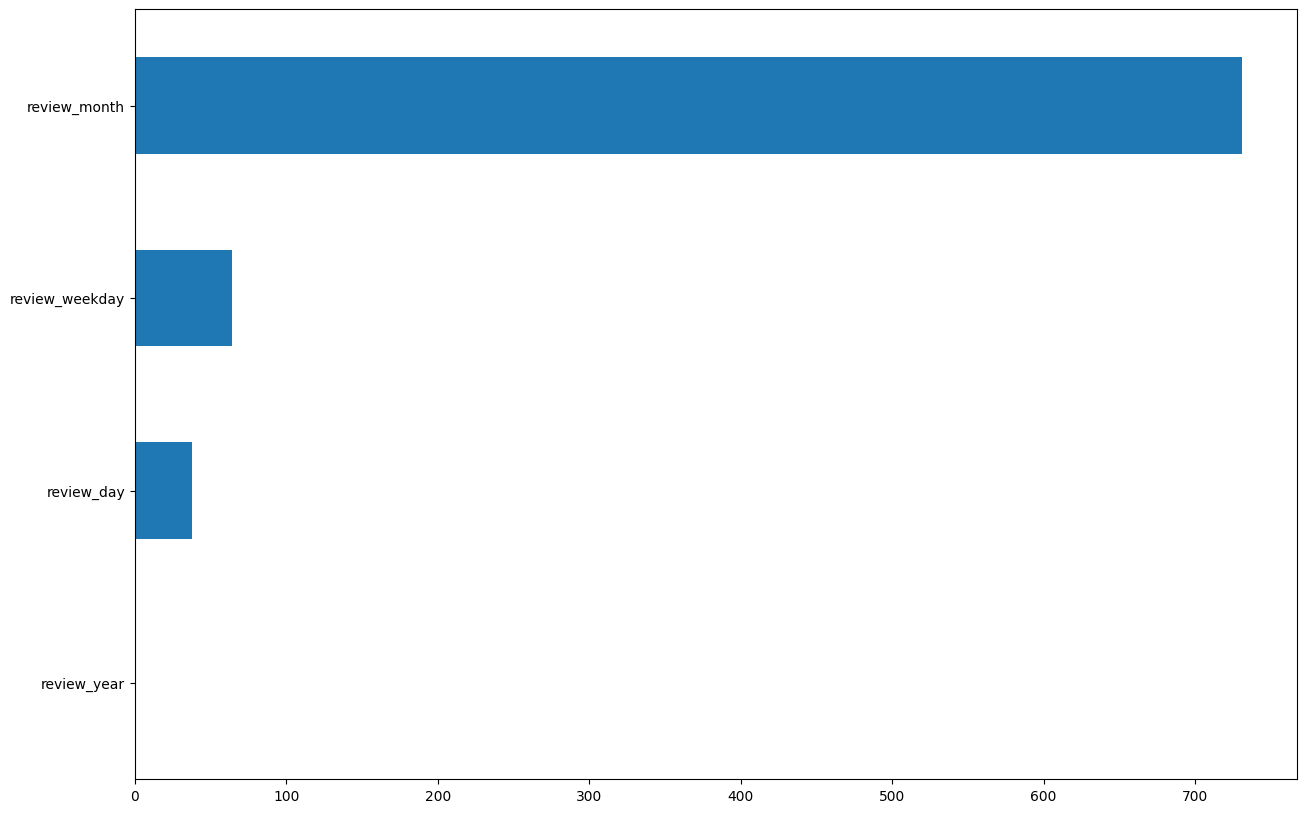

In [28]:
# оценим влияние категориальных признаков

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

y=y.astype('int')

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot: >

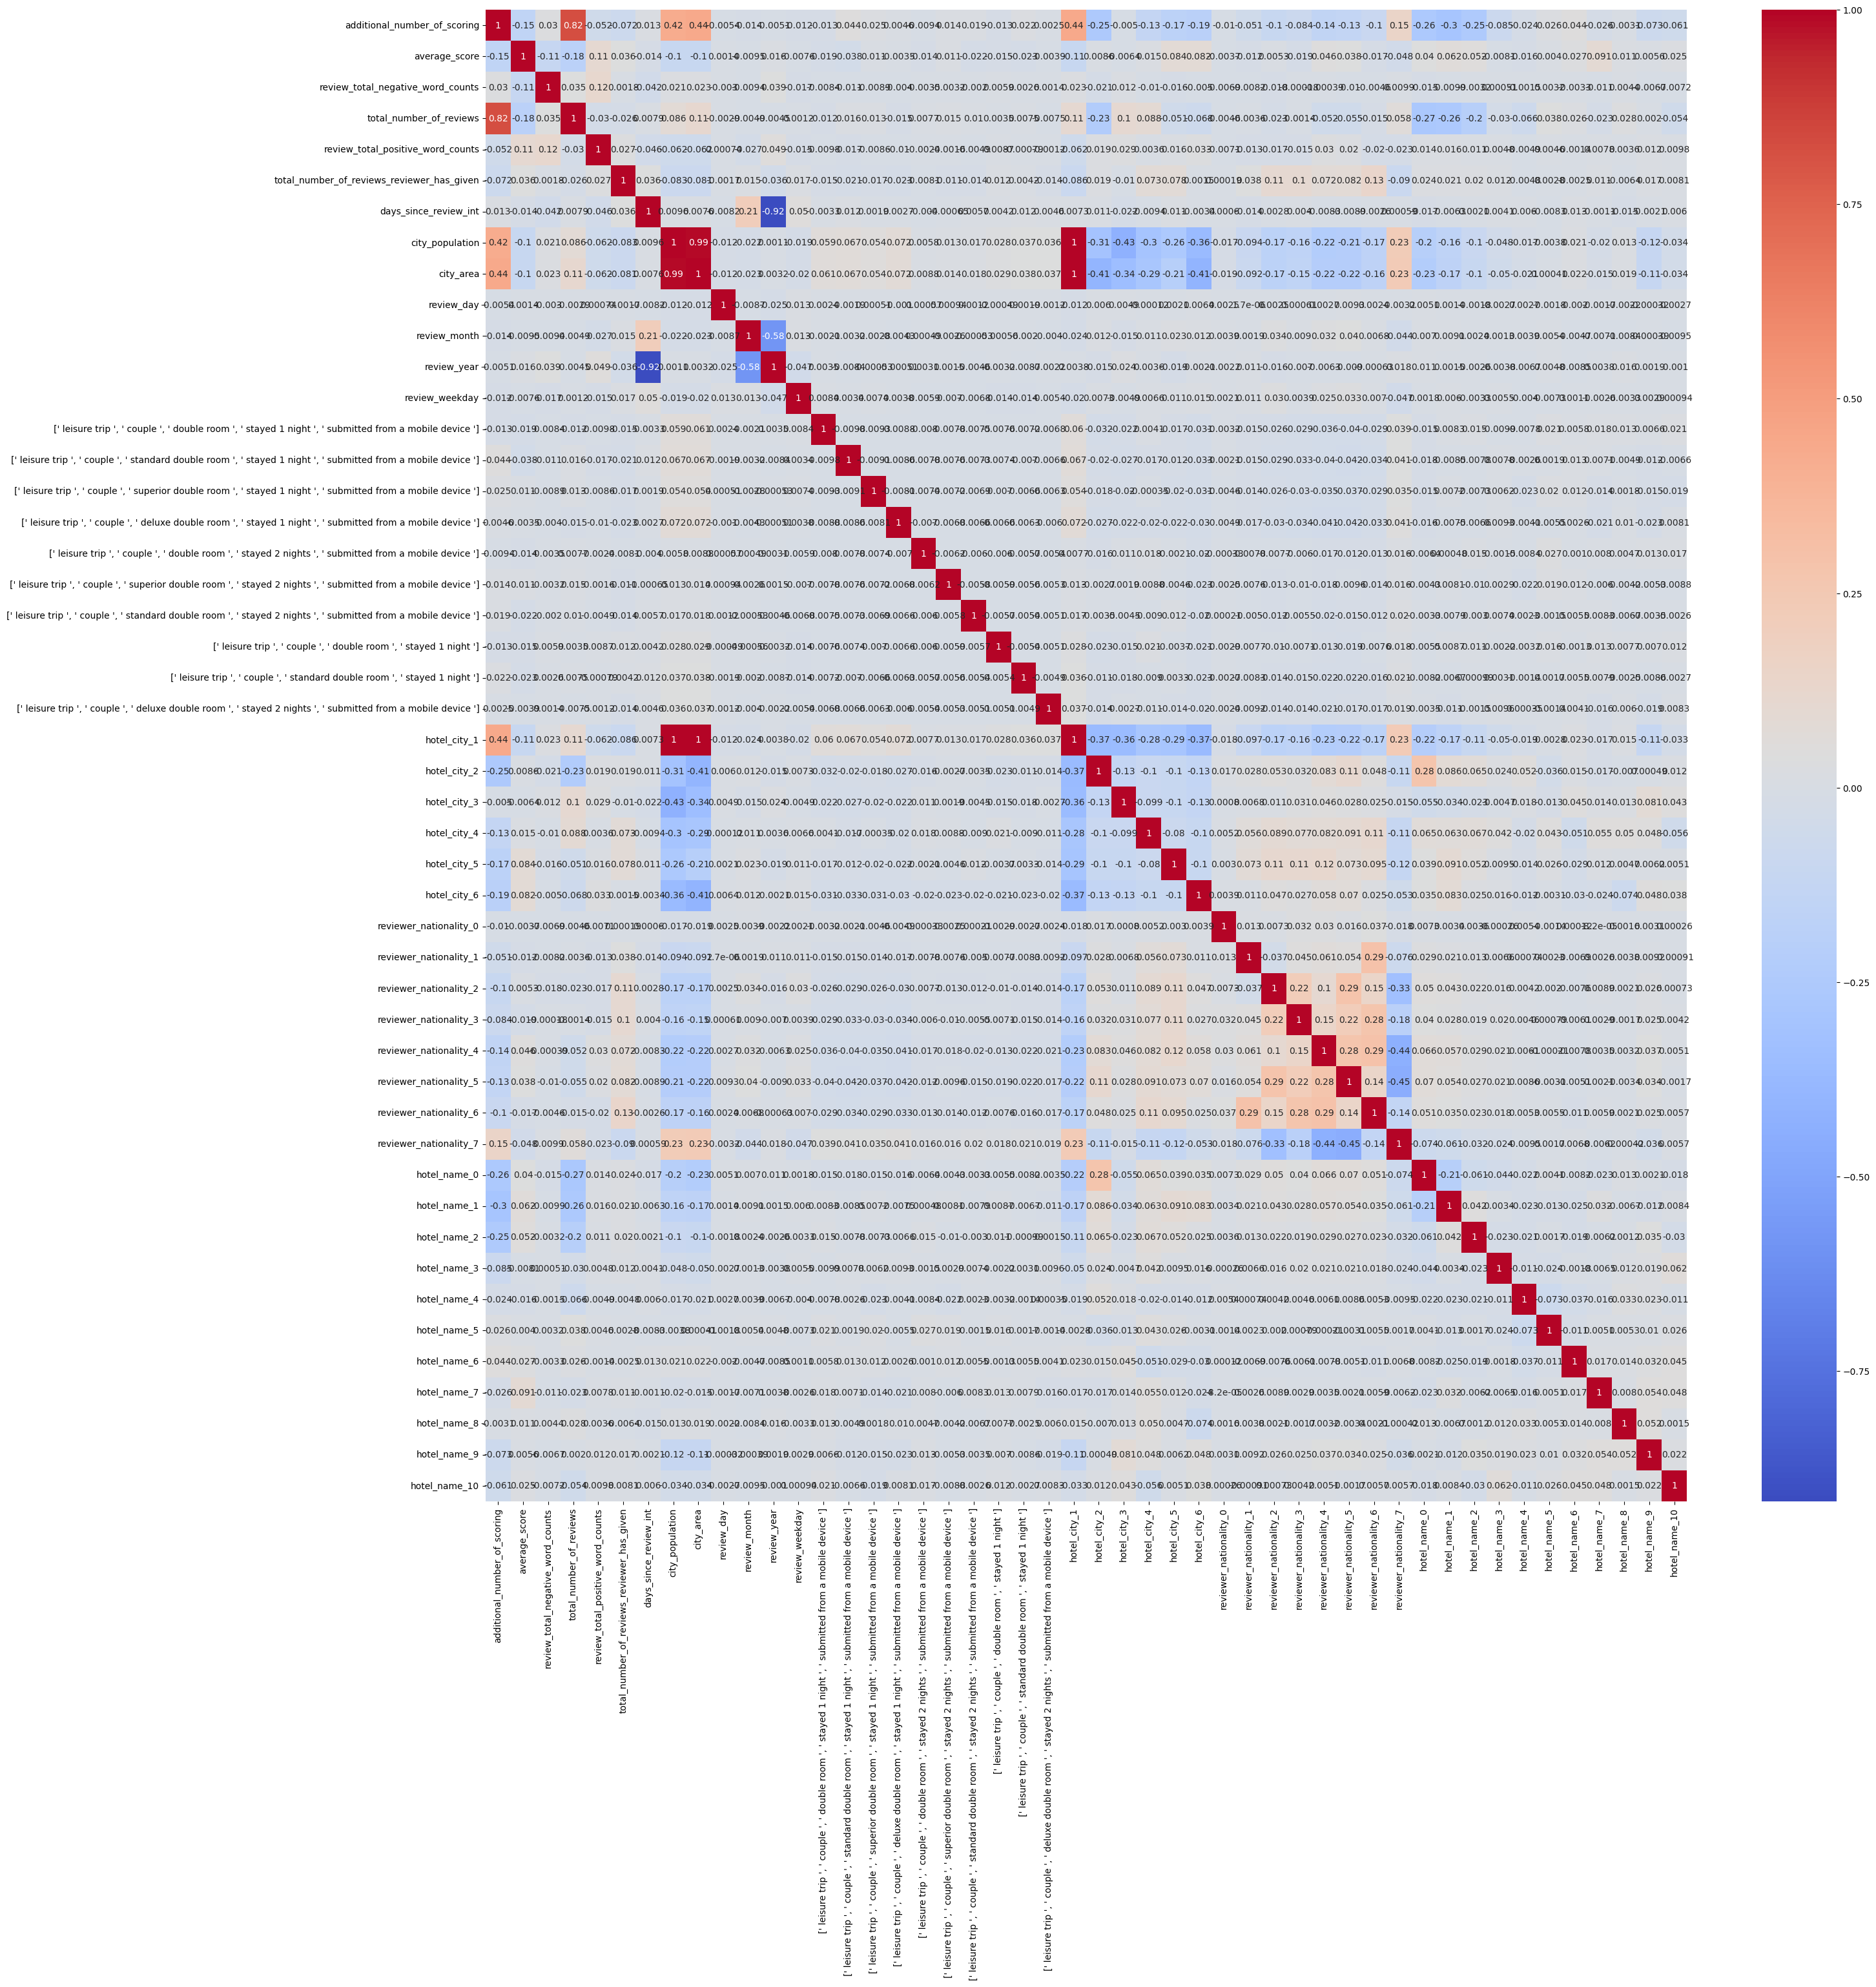

In [30]:
# оценим корреляцию признаков

plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(train_data.drop('reviewer_score',axis=1).corr(), annot=True, cmap='coolwarm')